(6750281, 6)
         Timestamp     Open     High      Low    Close    Volume
6750280        NaN  57854.0  57864.0  57835.0  57835.0  1.353466
            Timestamp       Open       High        Low      Close    Volume
0        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
1        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
2        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
3        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
4        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
...               ...        ...        ...        ...        ...       ...
6750275  1.737936e+09  102518.00  102559.00  102506.00  102558.00  0.771165
6750276  1.737936e+09  102628.00  102669.00  102608.00  102611.00  0.086742
6750277  1.737936e+09  102659.00  102712.00  102657.00  102712.00  0.488757
6750278  1.737936e+09  102631.00  102631.00  102573.00  102573.00  0.126719
6750279  1.737936e+09

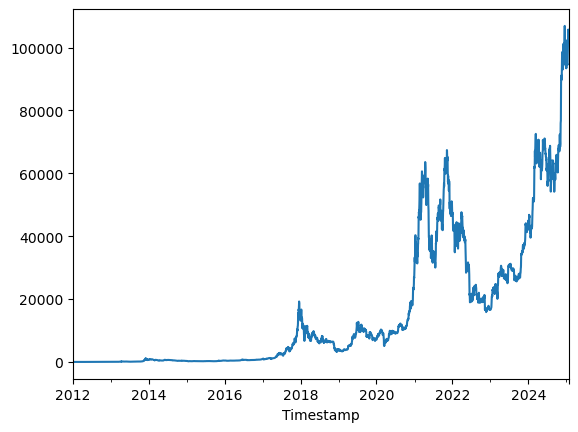

In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
# Cargamos el csv
train = pd.read_csv('btcusd_1-min_data.csv')

print(train.shape)

# Mostramos 10 registros al azar
train.sample(10)

#miro donde hay nulls si los hay
train.isna().sum()

filas_con_nulos = train[train.isnull().any(axis=1)]
print(filas_con_nulos)

train = train.dropna()
print(train)

train['Timestamp'] = pd.to_datetime(train['Timestamp'], unit='s') 
train.set_index('Timestamp', inplace=True)
print(train)

# Calcular la media por hora y rellenar posibles nulos
data_hour = train['Close'].resample('d').mean().ffill()

# Visualizamos la serie completa
data_hour.plot()
plt.show()

In [2]:
# 1 año a considerar en el conjunto de test
n_steps = 365

# Dividimos la serie en train y test
train_size = len(data_hour) - n_steps
train, test = data_hour[:train_size], data_hour[train_size:]

In [3]:
train_log = np.log(train)

In [4]:
# Aplicar auto_arima para encontrar los mejores parámetros
m=52
modelo_auto = auto_arima(train_log, start_p=1, start_q=1, max_p=20, max_q=20, max_order=60,
                         seasonal=True, stepwise=True, trace=True, error_action='ignore',
                         m=52, suppress_warnings=True)

# Mostrar resumen del modelo seleccionado
print(modelo_auto.summary())

# Obtener los parámetros óptimos
p, d, q = modelo_auto.order

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=-16808.587, Time=36.94 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=-16624.386, Time=0.74 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=-16793.416, Time=23.18 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=-16811.966, Time=8.75 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=-16612.438, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=-16809.952, Time=0.81 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=-16809.970, Time=10.79 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=-16810.048, Time=68.50 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=-16811.971, Time=7.74 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=-16810.046, Time=94.66 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=-16808.046, Time=93.14 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=-16625.834, Time=8.75 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=-16810.590, Time=41.15 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=-16810.940

In [5]:
# Ajustamos el modelo ARIMA

forecast = modelo_auto.predict(n_steps)
forecast = np.exp(forecast)
forecast_index = test.index

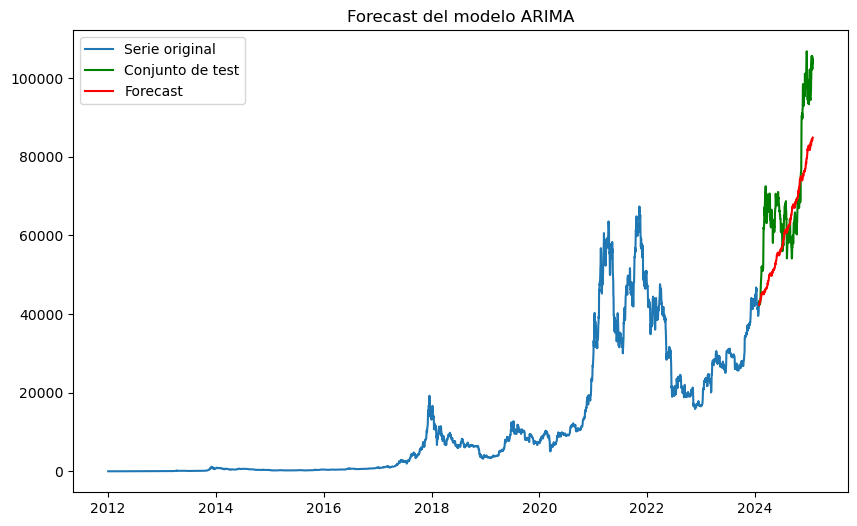

Mean Absolute Error: 10839.656896623106
Mean Absolute Error: 0.1476546223406955


In [17]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.savefig("Forecast_log_ARIMA_monthly.png")
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')
mape = mean_absolute_percentage_error(test, forecast)
print(f'Mean Absolute Error: {mape}')

In [7]:
model = SARIMAX(train_log, order=(p, d, q), seasonal_order=(p, d, q, m))
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast = np.exp(forecast)
forecast_index = test.index

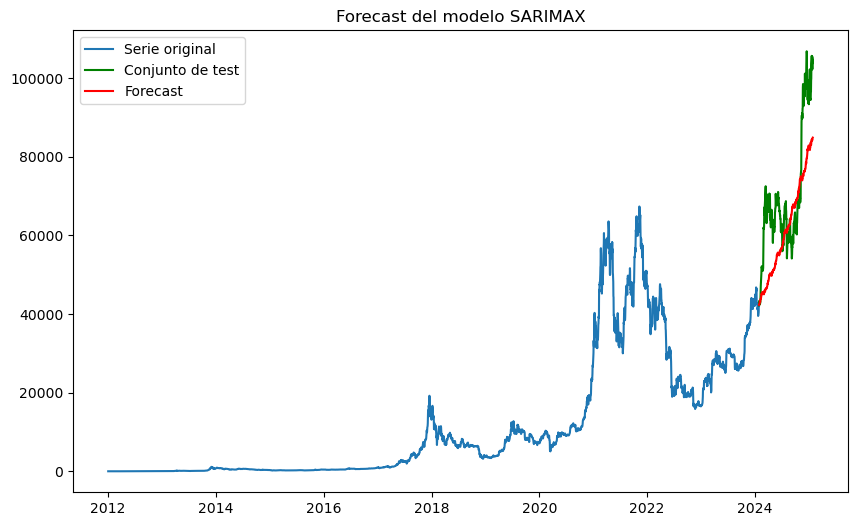

Mean Absolute Error: 10839.656896623106
Mean Absolute Error: 0.1476546223406955


In [19]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo SARIMAX')
plt.savefig("Forecast_log_SARIMAX_monthly.png")
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')
mape = mean_absolute_percentage_error(test, forecast)
print(f'Mean Absolute Error: {mape}')